In [1]:
# import block
# some of these may not be needed
import numpy as np
from astropy.io import fits
import pdb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.lines import Line2D
import matplotlib
from astropy.visualization import hist
from datetime import datetime
from pathlib import Path
import os
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D,Gaussian2D,Polynomial2D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData, StdDevUncertainty
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from imexam.imexamine import Imexamine
from astropy.coordinates import SkyCoord
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

# grab show_image
phot_tutorial_dir = '/Users/polinapetrov/F21/ASTR8060/phot_tutorial/notebooks'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

Ginga not installed, use other viewer, or no viewer


In [2]:
# plotting defaults
# Use custom style for larger fonts and figures
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below"
rc('font', size=12)
rc('axes', grid=True)

In [3]:
data_dir = '/Users/polinapetrov/F21/ASTR8060/Imaging/'
reduced_dir = '/Users/polinapetrov/F21/ASTR8060/reduced_2/'

In [71]:
def get_phot(file,approx_pos):
    #print(file)
    '''
    This function takes an input file, list of positions for stars to find, and plot title.
    
    It executes the following steps:
    1. Read in the data.
    2. Find all sources in the image. It assumes the FWHM is approximately 4 pix and finds everything greater than 10 sigma.
    3. It collects the info for the sources given in the input position list, matching within 10 pixel positions.
    4. It puts r=10pix apertures on each of these stars, as well as r_in=15, r_out=20 background annuli.
    5. It calculates background-subtracted instrumental magnitudes.
    6. It plots the image and apertures for visual inspection.
    7. It returns a table of photometry.
    '''
    fwhm       = 4.0
    source_snr = 10

    sci        = CCDData.read(file,unit='adu')
    data       = sci.data
    hdr        = sci.header
    
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
    daofind = DAOStarFinder(fwhm=fwhm, threshold=source_snr*std)    
    sources = daofind(data)
    
    positions = np.zeros_like(approx_pos)
    for position,i in zip(approx_pos,range(np.shape(approx_pos)[0])):
        #print(position)
        #print('')
        match = np.where((abs(sources['xcentroid']-position[0])<10) & (abs(sources['ycentroid']-position[1])<10))[0][0]
        positions[i] = (sources['xcentroid'][match],sources['ycentroid'][match])
          
    # photometry
    # biggest FWHM is 4.2 pix
    aperture  = CircularAperture(positions, r=4)
    phot = aperture_photometry(data, aperture)
    for col in phot.colnames:
        phot[col].info.format = '%.8g'              # for consistent table output
        
    # calculate the mean background
    # note that for PG1633+099, this will include two little stars :(
    annulus_aperture = CircularAnnulus(positions, r_in=15., r_out=20.)
    bg   = aperture_photometry(data,annulus_aperture)
    for col in bg.colnames:
        bg[col].info.format = '%.8g'                # for consistent table output
    msky = bg['aperture_sum']/annulus_aperture.area # get bg cts/pixel
    
    phot['inst_mag'] = -2.5 * np.log10(phot.columns['aperture_sum']-msky*aperture.area)
      
    # show the image with apertures
    #fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    #show_image(data, cmap='gray', ax=ax, fig=fig)
    #aperture.plot(color='green', lw=1.5, alpha=0.5) # apertures
    #annulus_aperture.plot(color='red', lw=1.5, alpha=0.5)                        # bg annulus
    #ax.set_xlim([800,1500])
    #ax.set_ylim([800,1500])
    #plt.title(title)
    #plt.tight_layout()
    #plt.show()
    
    return phot

# Q1

Plot your standard star instrumental magnitudes from HW6 versus their airmass (or since you have many different standard stars taken at different airmass, plot the difference between the accepted magnitude and your instrumental magnitude versus airmass). Use one of the linear fitting routines in Python to do a least squares fit to find and plot the extinction coefficients at each filter. You can find the standard star magnitudes and colors in Landolt (1992).

In [5]:
#getting pg1633 science frames
imgs = ccdp.ImageFileCollection(reduced_dir,glob_include='*otzf.fits')
#sci_files = imgs.files_filtered(imagetyp='science',object='pg1633',include_path=True)
#sci = ((imgs.summary['imagetyp'] == 'science') & (imgs.summary['filter'] != 'Ha'))
#sci_filters = set(imgs.summary['filter'][sci])
sci_filters = ['U','B','V','R','I']

In [6]:
# these are found from imxam for the V filter, but work well enough to find positions in the other filters
# it is important that the positions go in order 1-A-B-C-D to match the standard mags stored in the Landolt table
approx_pos = [[(988.8683,1049.2803),(1044.8029,1043.2159),(1251.6695,1221.4295),(1363.9839,1230.9691),(1444.0144,1182.0372)],\
[(987.9844,1049.2036),(1043.8968,1043.1361),(1250.6889,1221.1958),(1363.0112,1230.7516),(1443.0305,1181.8385)],\
[(931.8118,1043.4529),(987.6939,1037.3564),(1194.6650,1215.5002),(1307.0202,1225.0282),(1386.9956,1176.1044)],\
[(932.0204,1043.5176),(987.9188,1037.3954),(1194.7984,1215.5333),(1307.1397,1225.0323),(1387.0961,1176.0627)],\
[(924.4201,1037.0850),(980.2808,1030.9915),(1187.3280,1208.8491),(1299.5213,1218.2871),(1379.4235,1169.3869)],\
[(925.3480,1036.7100),(981.2349,1030.6284),(1188.1673,1208.4725),(1300.4663,1217.9357),(1380.4332,1168.9797)],\
[(838.3982,1039.8684),(894.1732,1033.8111),(1101.0422,1211.7489),(1213.2663,1221.1237),(1293.3098,1172.1284)],\
[(838.1403,1039.7337),(893.9993,1033.6562),(1100.9368,1211.3933),(1213.1794,1220.8576),(1293.1324,1171.9191)]]

# loop over the filters, store photometry in an array
photometry = []
for filtr,ii in zip(sci_filters,range(len(sci_filters))):
    # get files in this filter
    sci_infilter = imgs.files_filtered(imagetyp='science',object='pg1633',filter=filtr,include_path=True)
    
    if filtr=='V': # skip the linearity test
        sci_infilter = sci_infilter[7:]
        
    if filtr=='I': #isn't finding the position for the last file, taking it out
        sci_infilter.pop()

    # do aperture photometry
    phot = [get_phot(file,approx_pos[i]) for file,i in zip(sci_infilter,range(len(sci_infilter)))]
    photometry.append(phot)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a081otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(988.8683, 1049.2803)

(1044.8029, 1043.2159)

(1251.6695, 1221.4295)

(1363.9839, 1230.9691)

(1444.0144, 1182.0372)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a082otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(987.9844, 1049.2036)

(1043.8968, 1043.1361)

(1250.6889, 1221.1958)

(1363.0112, 1230.7516)

(1443.0305, 1181.8385)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a130otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(931.8118, 1043.4529)

(987.6939, 1037.3564)

(1194.665, 1215.5002)

(1307.0202, 1225.0282)

(1386.9956, 1176.1044)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a131otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(932.0204, 1043.5176)

(987.9188, 1037.3954)

(1194.7984, 1215.5333)

(1307.1397, 1225.0323)

(1387.0961, 1176.0627)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a202otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(924.4201, 1037.085)

(980.2808, 1030.9915)

(1187.328, 1208.8491)

(1299.5213, 1218.2871)

(1379.4235, 1169.3869)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a203otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(925.348, 1036.71)

(981.2349, 1030.6284)

(1188.1673, 1208.4725)

(1300.4663, 1217.9357)

(1380.4332, 1168.9797)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a237otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(838.3982, 1039.8684)

(894.1732, 1033.8111)

(1101.0422, 1211.7489)

(1213.2663, 1221.1237)

(1293.3098, 1172.1284)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a238otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(838.1403, 1039.7337)

(893.9993, 1033.6562)

(1100.9368, 1211.3933)

(1213.1794, 1220.8576)

(1293.1324, 1171.9191)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a083otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(988.8683, 1049.2803)

(1044.8029, 1043.2159)

(1251.6695, 1221.4295)

(1363.9839, 1230.9691)

(1444.0144, 1182.0372)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a084otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(987.9844, 1049.2036)

(1043.8968, 1043.1361)

(1250.6889, 1221.1958)

(1363.0112, 1230.7516)

(1443.0305, 1181.8385)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a132otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(931.8118, 1043.4529)

(987.6939, 1037.3564)

(1194.665, 1215.5002)

(1307.0202, 1225.0282)

(1386.9956, 1176.1044)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a133otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(932.0204, 1043.5176)

(987.9188, 1037.3954)

(1194.7984, 1215.5333)

(1307.1397, 1225.0323)

(1387.0961, 1176.0627)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a204otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(924.4201, 1037.085)

(980.2808, 1030.9915)

(1187.328, 1208.8491)

(1299.5213, 1218.2871)

(1379.4235, 1169.3869)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a205otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(925.348, 1036.71)

(981.2349, 1030.6284)

(1188.1673, 1208.4725)

(1300.4663, 1217.9357)

(1380.4332, 1168.9797)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a239otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(838.3982, 1039.8684)

(894.1732, 1033.8111)

(1101.0422, 1211.7489)

(1213.2663, 1221.1237)

(1293.3098, 1172.1284)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a240otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(838.1403, 1039.7337)

(893.9993, 1033.6562)

(1100.9368, 1211.3933)

(1213.1794, 1220.8576)

(1293.1324, 1171.9191)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a085otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(988.8683, 1049.2803)

(1044.8029, 1043.2159)

(1251.6695, 1221.4295)

(1363.9839, 1230.9691)

(1444.0144, 1182.0372)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a086otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(987.9844, 1049.2036)

(1043.8968, 1043.1361)

(1250.6889, 1221.1958)

(1363.0112, 1230.7516)

(1443.0305, 1181.8385)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a134otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(931.8118, 1043.4529)

(987.6939, 1037.3564)

(1194.665, 1215.5002)

(1307.0202, 1225.0282)

(1386.9956, 1176.1044)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a135otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(932.0204, 1043.5176)

(987.9188, 1037.3954)

(1194.7984, 1215.5333)

(1307.1397, 1225.0323)

(1387.0961, 1176.0627)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a206otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(924.4201, 1037.085)

(980.2808, 1030.9915)

(1187.328, 1208.8491)

(1299.5213, 1218.2871)

(1379.4235, 1169.3869)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a207otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(925.348, 1036.71)

(981.2349, 1030.6284)

(1188.1673, 1208.4725)

(1300.4663, 1217.9357)

(1380.4332, 1168.9797)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a241otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(838.3982, 1039.8684)

(894.1732, 1033.8111)

(1101.0422, 1211.7489)

(1213.2663, 1221.1237)

(1293.3098, 1172.1284)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a242otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(838.1403, 1039.7337)

(893.9993, 1033.6562)

(1100.9368, 1211.3933)

(1213.1794, 1220.8576)

(1293.1324, 1171.9191)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a087otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(988.8683, 1049.2803)

(1044.8029, 1043.2159)

(1251.6695, 1221.4295)

(1363.9839, 1230.9691)

(1444.0144, 1182.0372)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a088otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(987.9844, 1049.2036)

(1043.8968, 1043.1361)

(1250.6889, 1221.1958)

(1363.0112, 1230.7516)

(1443.0305, 1181.8385)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a136otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(931.8118, 1043.4529)

(987.6939, 1037.3564)

(1194.665, 1215.5002)

(1307.0202, 1225.0282)

(1386.9956, 1176.1044)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a137otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(932.0204, 1043.5176)

(987.9188, 1037.3954)

(1194.7984, 1215.5333)

(1307.1397, 1225.0323)

(1387.0961, 1176.0627)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a208otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(924.4201, 1037.085)

(980.2808, 1030.9915)

(1187.328, 1208.8491)

(1299.5213, 1218.2871)

(1379.4235, 1169.3869)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a209otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(925.348, 1036.71)

(981.2349, 1030.6284)

(1188.1673, 1208.4725)

(1300.4663, 1217.9357)

(1380.4332, 1168.9797)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a243otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(838.3982, 1039.8684)

(894.1732, 1033.8111)

(1101.0422, 1211.7489)

(1213.2663, 1221.1237)

(1293.3098, 1172.1284)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a244otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(838.1403, 1039.7337)

(893.9993, 1033.6562)

(1100.9368, 1211.3933)

(1213.1794, 1220.8576)

(1293.1324, 1171.9191)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a089otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(988.8683, 1049.2803)

(1044.8029, 1043.2159)

(1251.6695, 1221.4295)

(1363.9839, 1230.9691)

(1444.0144, 1182.0372)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a090otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(987.9844, 1049.2036)

(1043.8968, 1043.1361)

(1250.6889, 1221.1958)

(1363.0112, 1230.7516)

(1443.0305, 1181.8385)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a138otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(931.8118, 1043.4529)

(987.6939, 1037.3564)

(1194.665, 1215.5002)

(1307.0202, 1225.0282)

(1386.9956, 1176.1044)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a139otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(932.0204, 1043.5176)

(987.9188, 1037.3954)

(1194.7984, 1215.5333)

(1307.1397, 1225.0323)

(1387.0961, 1176.0627)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a210otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(924.4201, 1037.085)

(980.2808, 1030.9915)

(1187.328, 1208.8491)

(1299.5213, 1218.2871)

(1379.4235, 1169.3869)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a211otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(925.348, 1036.71)

(981.2349, 1030.6284)

(1188.1673, 1208.4725)

(1300.4663, 1217.9357)

(1380.4332, 1168.9797)

/Users/polinapetrov/F21/ASTR8060/reduced_2/a245otzf.fits


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
(838.3982, 1039.8684)

(894.1732, 1033.8111)

(1101.0422, 1211.7489)

(1213.2663, 1221.1237)

(1293.3098, 1172.1284)



In [7]:
print(len(photometry)) #each of 5 filters (U,B,V,R,I)
print(len(photometry[0])) #number of files in a given filter (8 for UBVR, 7 for I)
print(len(photometry[0][0])) #each of 5 standard stars (1,A,B,C,D)
print(len(photometry[0][0][0])) #5 values for each star: ID, xcenter, ycenter, aperture_sum, inst_mag

5
8
5
5


In [8]:
airmasses = [[1.18]*2+[1.23]+[1.24]+[1.49]*2+[2.15]*2]+[[1.18]*2+[1.24]*2+[1.51]*2+[2.19]*2]+[[1.18]*2+[1.24]*2+[1.52]*2+[2.21]*2]+[[1.18]*2+[1.24]*2+[1.53]*2+[2.23]*2]+[[1.18]+[1.17]+[1.24]*2+[1.53]*2+[2.26]]
colors = ['darkviolet','royalblue','forestgreen','crimson','goldenrod']

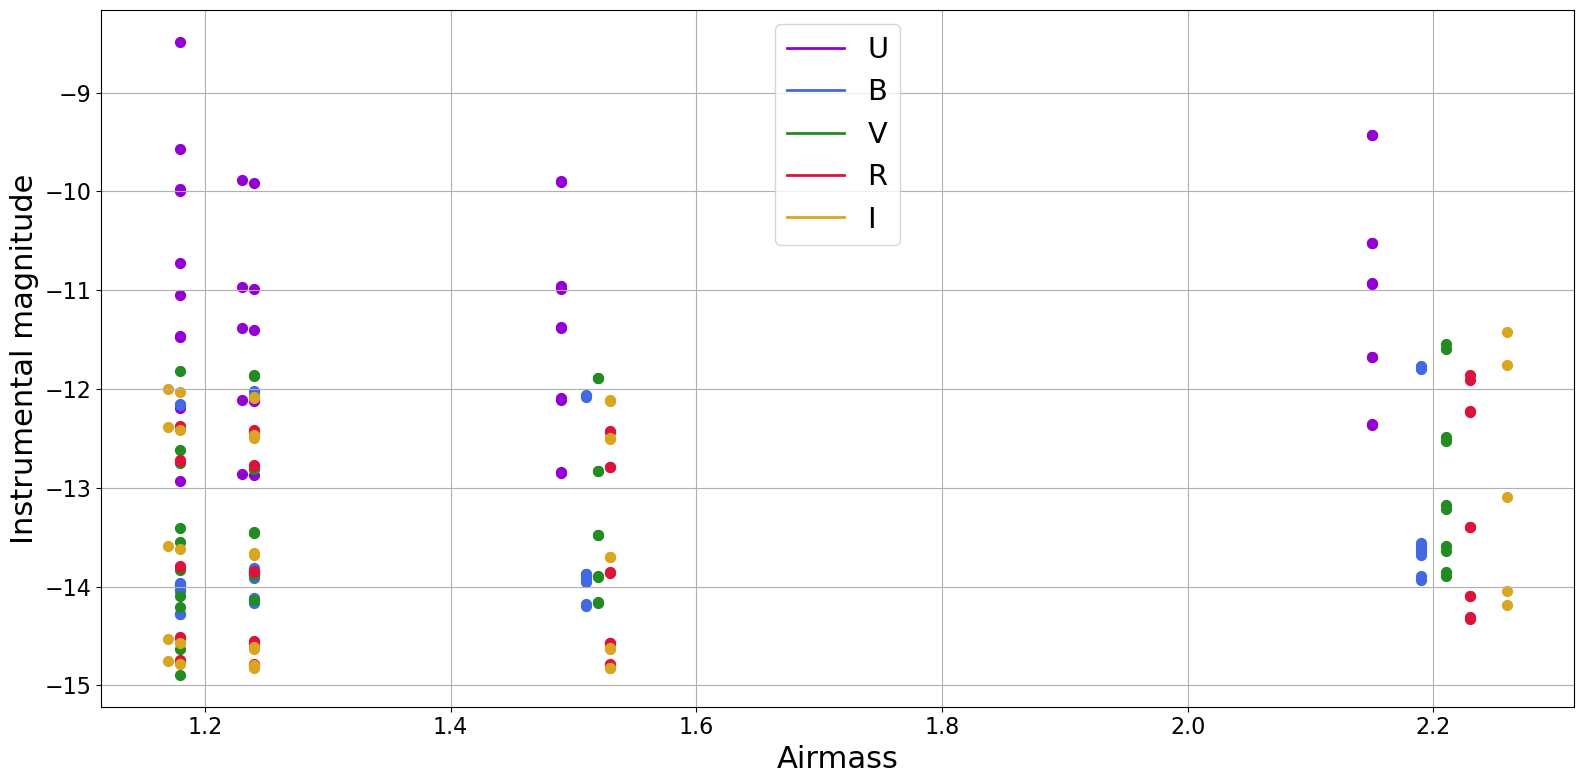

In [9]:
#plot of instrumental mags as a function of airmass

fig, ax = plt.subplots(figsize=(16, 8))
for i in range(0,len(photometry)):
    color = colors[i]
    for j in range(0,len(photometry[i])):
        airmass = airmasses[i][j]
        for k in range(0,len(photometry[i][j])):
            star = photometry[i][j][k]
            mag = star['inst_mag']
            ax.scatter(airmass, mag, color=color, marker='o', s=50)

ax.set_ylabel(r'Instrumental magnitude',fontsize=22)
ax.set_xlabel(r'Airmass',fontsize=22)

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color=colors[3], lw=2),
                Line2D([0], [0], color=colors[4], lw=2)]

ax.legend(custom_lines, ['U','B','V','R','I'], loc='upper center')
fig.tight_layout()

fig.tight_layout()

In [10]:
# create an astropy table with the standard star info
landolt = Table()
landolt['V']   = [14.397,15.256,12.969,13.229,13.691]
landolt['B-V'] = [-0.192,0.873,1.081,1.134,0.535] 
landolt['U-B'] = [-0.974,0.320,1.007,1.138,-0.025]
landolt['V-R'] = [-0.093,0.505,0.590,0.618,0.324]
landolt['R-I'] = [-0.116,0.511,0.502,0.523,0.327]
landolt['V-I'] = [-0.212,1.015,1.090,1.138,0.650]
landolt['B'] = landolt['B-V']+landolt['V']
landolt['U'] = landolt['U-B']+landolt['B']
landolt['R'] = landolt['V']-landolt['V-R']
landolt['I'] = landolt['V']-landolt['V-I']

landolt

V,B-V,U-B,V-R,R-I,V-I,B,U,R,I
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
14.397,-0.192,-0.974,-0.093,-0.116,-0.212,14.205,13.231,14.49,14.609
15.256,0.873,0.32,0.505,0.511,1.015,16.129,16.449,14.751,14.241
12.969,1.081,1.007,0.59,0.502,1.09,14.049999999999999,15.056999999999999,12.379,11.879
13.229,1.134,1.138,0.618,0.523,1.138,14.363,15.501,12.610999999999999,12.091
13.691,0.535,-0.025,0.324,0.327,0.65,14.226,14.201,13.367,13.041


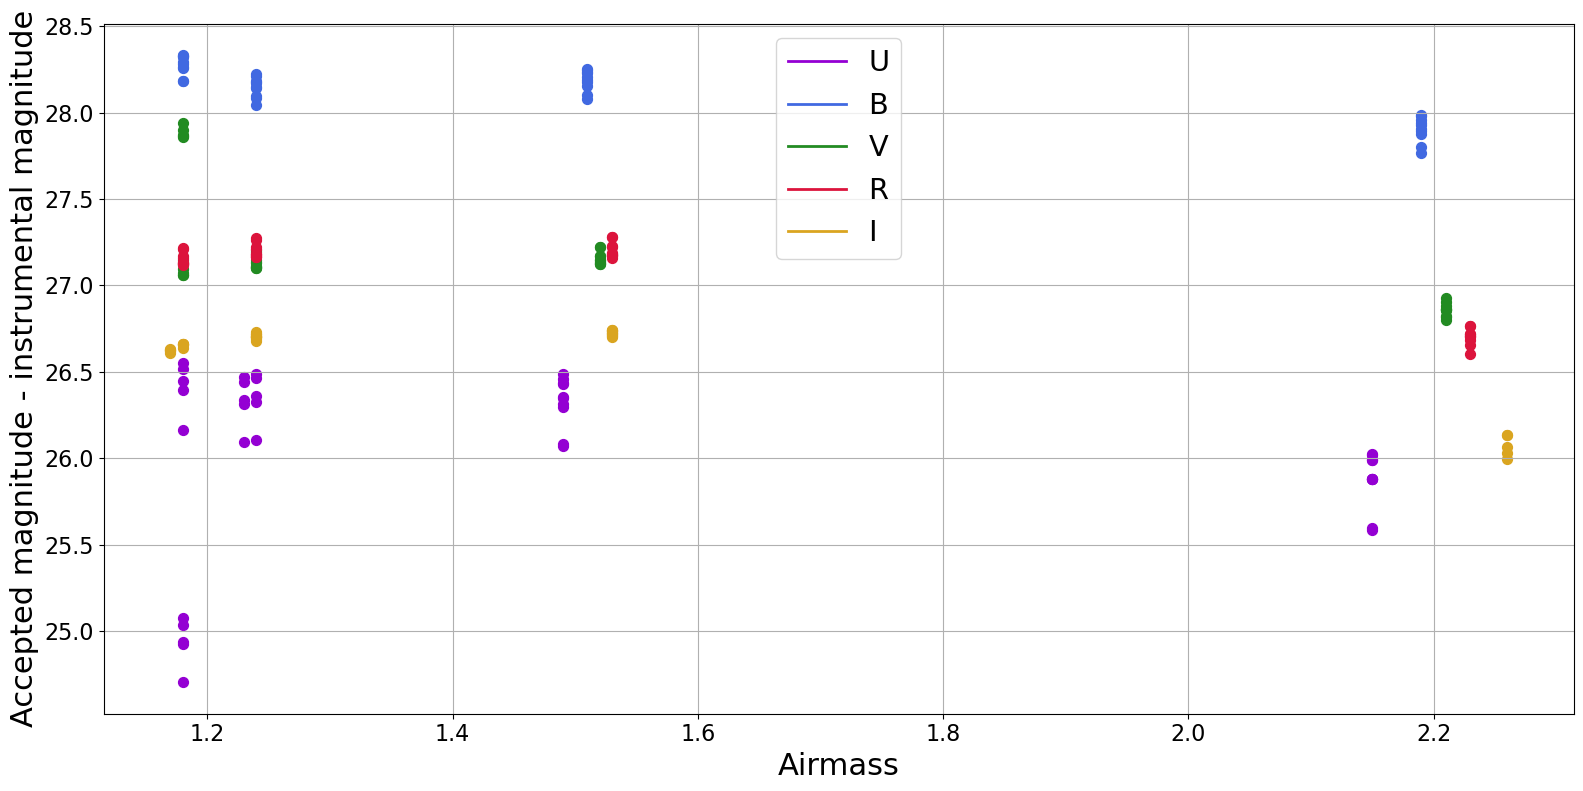

In [11]:
columns = [7,6,0,8,9] #columns: U=7, B=6, V=0, R=8, I=9

#second plot of difference between accepted mag and instrumental mag as a function of airmass

fig, ax = plt.subplots(figsize=(16, 8))
for i in range(0,len(photometry)):
    color = colors[i]
    for j in range(0,len(photometry[i])):
        airmass = airmasses[i][j]
        for k in range(0,len(photometry[i][j])):
            star = photometry[i][j][k]
            in_mag = star['inst_mag']
            acc_mag = landolt[k][columns[i]]
            ax.scatter(airmass, acc_mag-in_mag, color=color, marker='o', s=50)

ax.set_ylabel(r'Accepted magnitude - instrumental magnitude',fontsize=22)
ax.set_xlabel(r'Airmass',fontsize=22)

custom_lines = [Line2D([0], [0], color=colors[0], lw=2),
                Line2D([0], [0], color=colors[1], lw=2),
                Line2D([0], [0], color=colors[2], lw=2),
                Line2D([0], [0], color=colors[3], lw=2),
                Line2D([0], [0], color=colors[4], lw=2)]

ax.legend(custom_lines, ['U','B','V','R','I'], loc='upper center')
fig.tight_layout()

Extinction coefficient for U filter: 0.12554815465550787
Intercept: 26.24359806822887
Extinction coefficient for B filter: 0.3226764233838469
Intercept: 28.623288085826225
Extinction coefficient for V filter: 0.46506980368682843
Intercept: 27.87497587053827
Extinction coefficient for R filter: 0.4645916376410092
Intercept: 27.78350111434505
Extinction coefficient for I filter: 0.5216810819504027
Intercept: 27.358175277414897


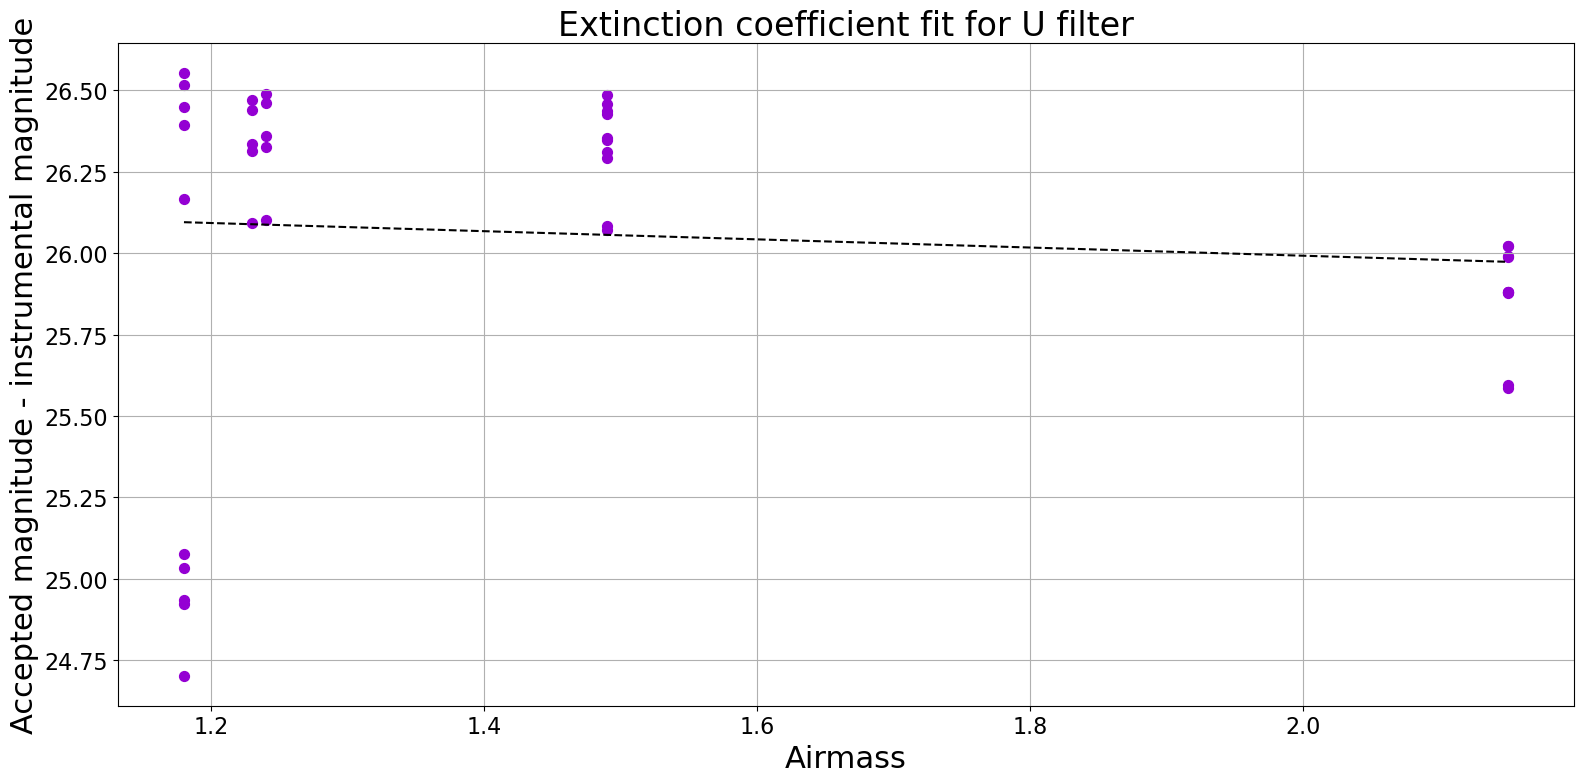

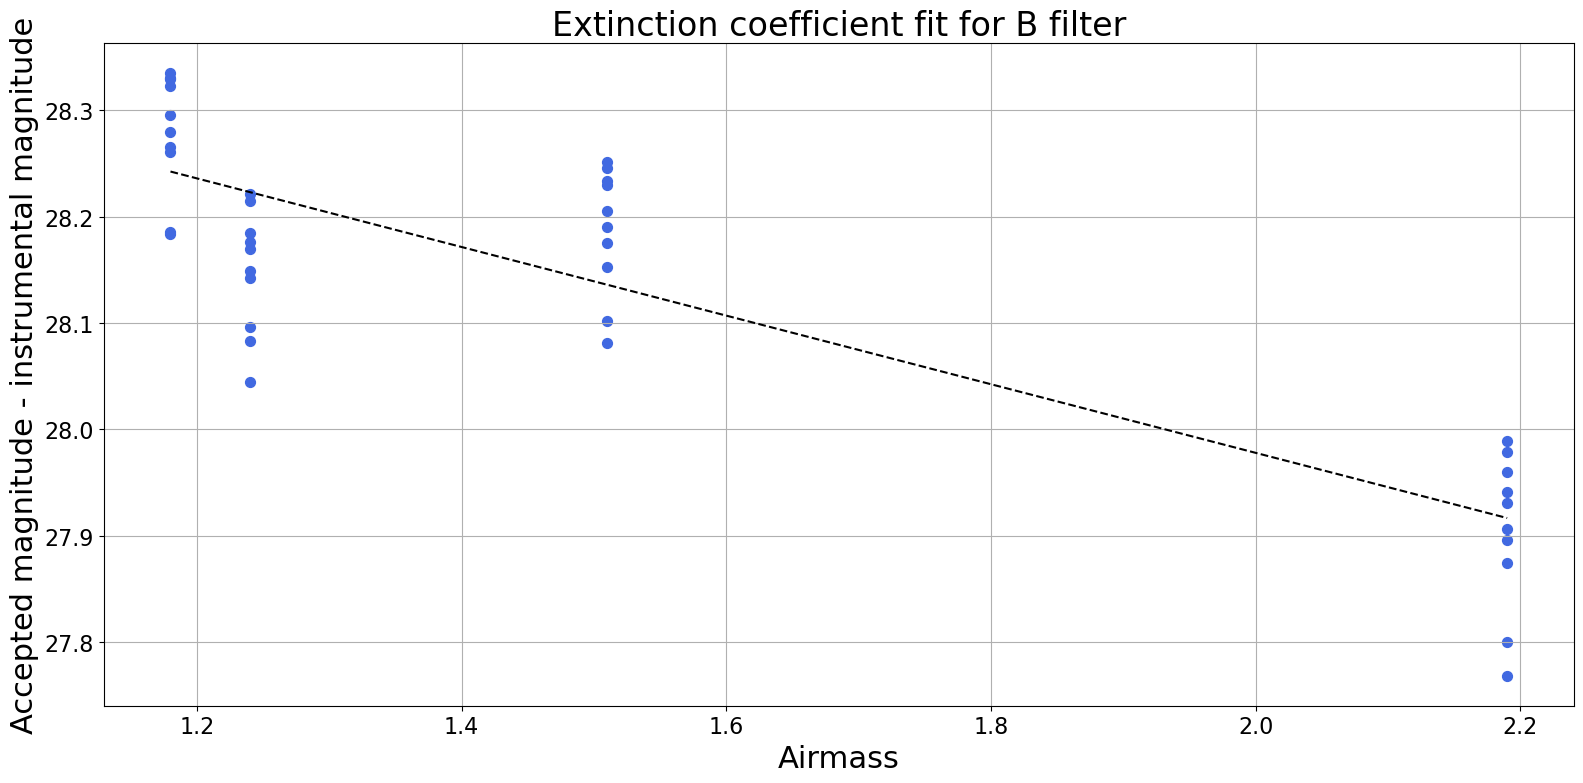

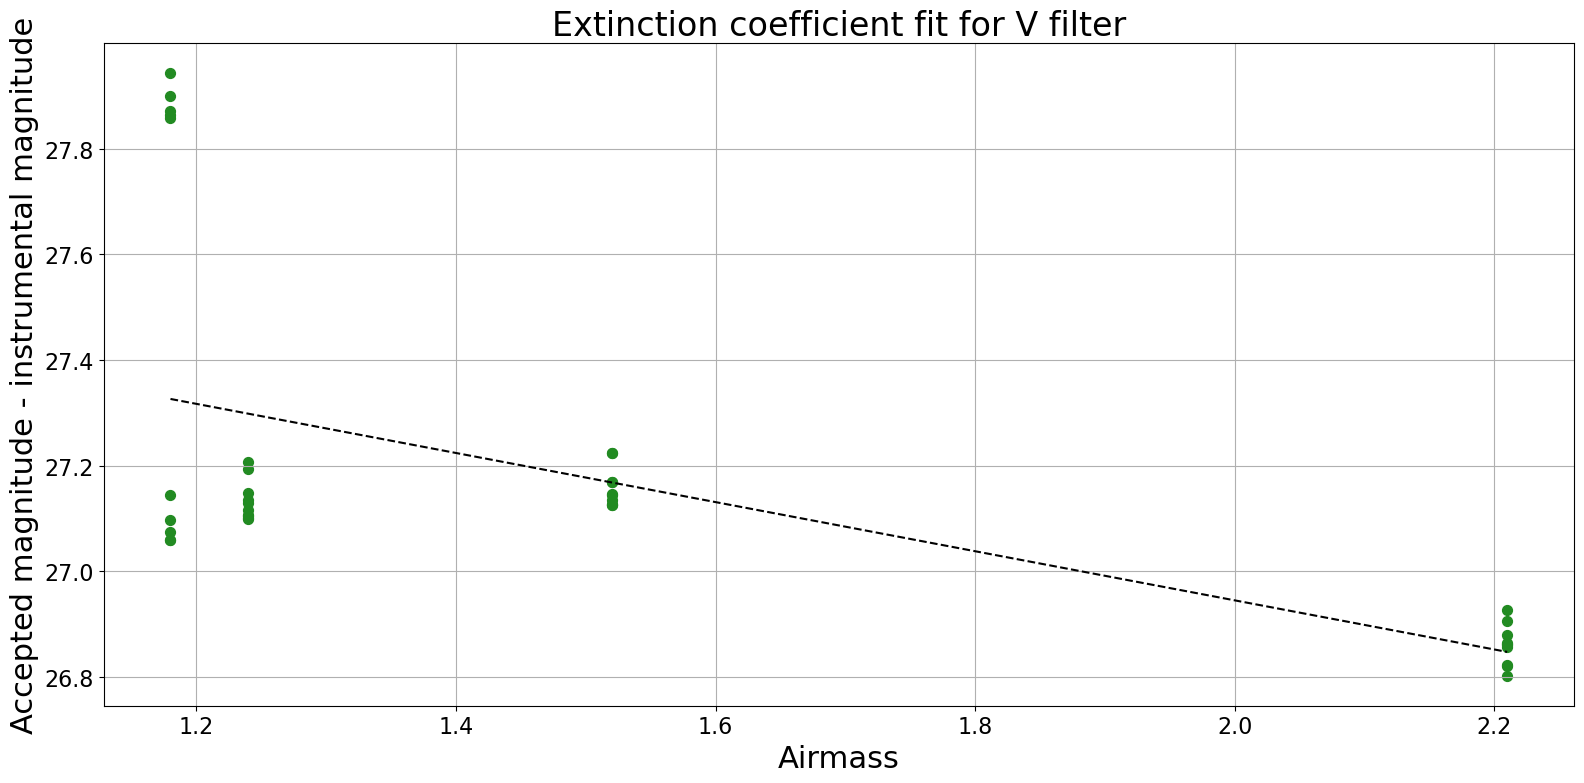

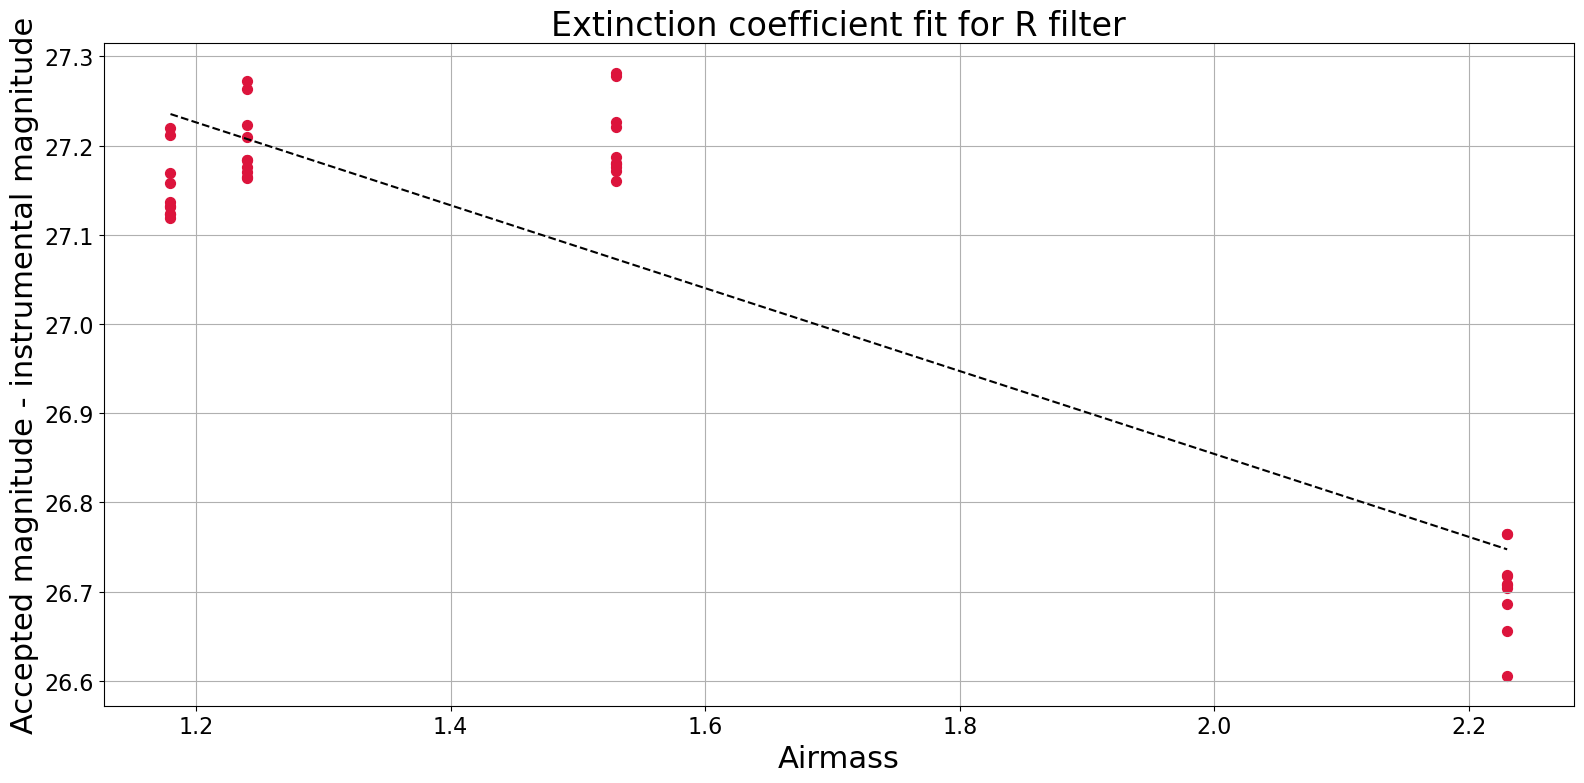

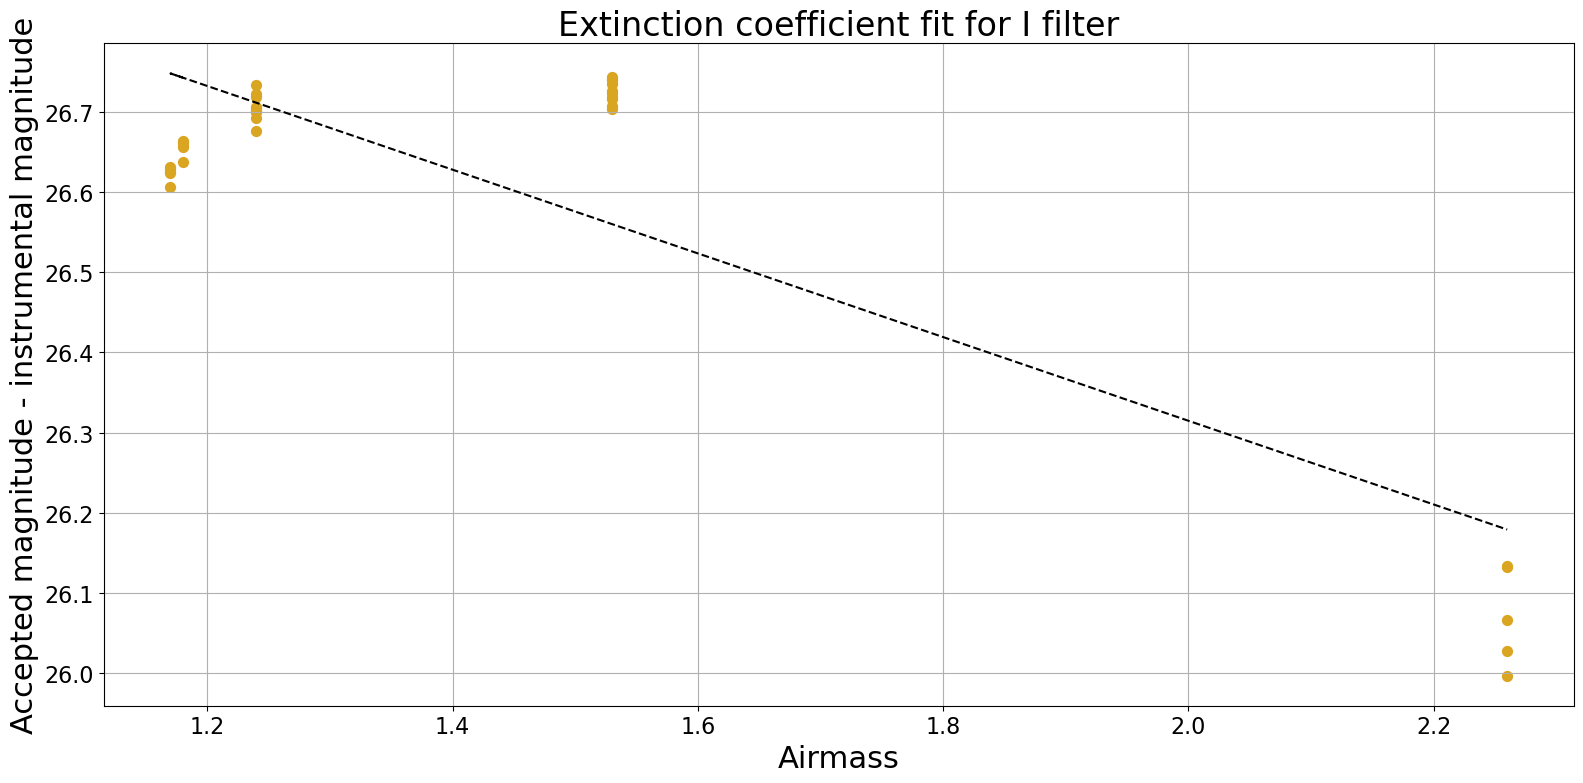

In [12]:
#plotting extinction coefficient fits for each filter

ext_coeffs = []

for i in range(0,len(photometry)):
    fig = plt.figure(i+1, figsize=(16, 8))
    diff_toplot = []
    am_toplot = []
    color = colors[i]
    for j in range(0,len(photometry[i])):
        airmass = airmasses[i][j]
        for k in range(0,len(photometry[i][j])):
            star = photometry[i][j][k]
            in_mag = star['inst_mag']
            acc_mag = landolt[k][columns[i]]
            diff_toplot.append(acc_mag-in_mag)
            am_toplot.append(airmass)
            plt.scatter(airmass, acc_mag-in_mag, color=color, marker='o', s=50)
    m, b = np.polyfit(am_toplot, diff_toplot, 1)
    ext_coeffs.append(m*-1)
    print('Extinction coefficient for '+sci_filters[i]+' filter:', m*-1)
    print('Intercept:', b)
    plt.plot(np.array(am_toplot), m*np.array(am_toplot) + b, color='black', ls='dashed')
    plt.ylabel(r'Accepted magnitude - instrumental magnitude',fontsize=22)
    plt.xlabel(r'Airmass',fontsize=22)
    plt.title('Extinction coefficient fit for '+sci_filters[i]+' filter')
    fig.tight_layout()

# Q2

After extinction correcting your standard stars to zero airmasses (i.e., you’re correcting to the top of the atmosphere), make a plot of the difference between real magnitudes and instrumental magnitudes using your standard stars as a function of V−R color and B−V color. Fit a linear relation to this trend. The fit gives you your instrumental zero points and the first order color term which let you transform your instrumental photometry to the standard system. Tabulate the instrumental zero point and first order color terms for each band in a neat, digestible way.

In [13]:
#first need to subtract appropriate ext coeff from each inst mag

ext_corrected = []

for f in range(0,5): #by filter
    coeff = ext_coeffs[f]
    filtr_array = []
    for file in range(0,len(photometry[f])): #by file
        airm = airmasses[f][file]
        file_array = []
        for star in photometry[f][file]:
            correct = star['inst_mag']-coeff*airm
            file_array.append(correct)
        filtr_array.append(file_array)
    ext_corrected.append(filtr_array)

V transformation coefficient: 0.17712252162822534
V instrumental zero point: 27.88597734273399


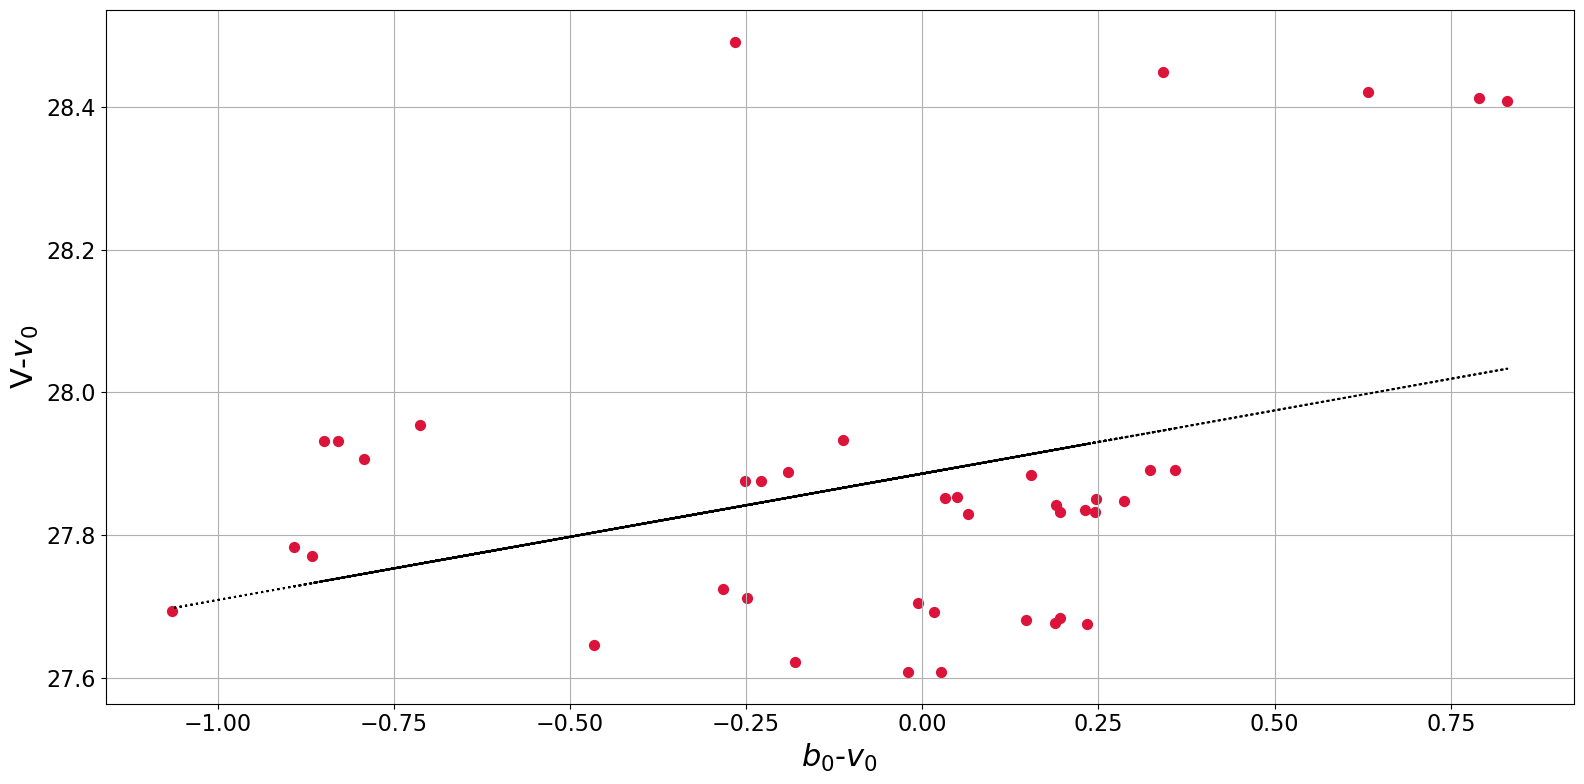

In [14]:
#plotting difference between inst and real (V-V_0) as a function of B-V real mags

x = []
y = []

fig = plt.figure(figsize=(16, 8))
for file in range(0,len(photometry[1])):             #for each file
    for star in range(0,len(photometry[1][file])):   #for each star
            V = landolt[star][columns[2]]            #V real mag for appropriate star in appropriate mag column
            v_0 = ext_corrected[2][file][star]       #v_0 inst mag
            b_0 = ext_corrected[1][file][star]       #b_0 inst mag
            x.append(b_0-v_0)
            y.append(V-v_0)
            plt.scatter(b_0-v_0, V-v_0, color='crimson', marker='o', s=50)

transf_coeff, zero_point = np.polyfit(x, y, 1)
V_coeff = transf_coeff
V_zp = zero_point
print('V transformation coefficient:', V_coeff)
print('V instrumental zero point:', V_zp)
plt.plot(np.array(x), transf_coeff*np.array(x) + zero_point, color='black', ls='dotted')
    
plt.xlabel(r'$b_0$-$v_0$',fontsize=22)
plt.ylabel(r'V-$v_0$',fontsize=22)
fig.tight_layout()

B-V transformation coefficient: 0.9380110918094603
B-V instrumental zero point: 0.7444619468769452
B transformation coefficient: 1.1151336134376857
B instrumental zero point: 28.630439289610937


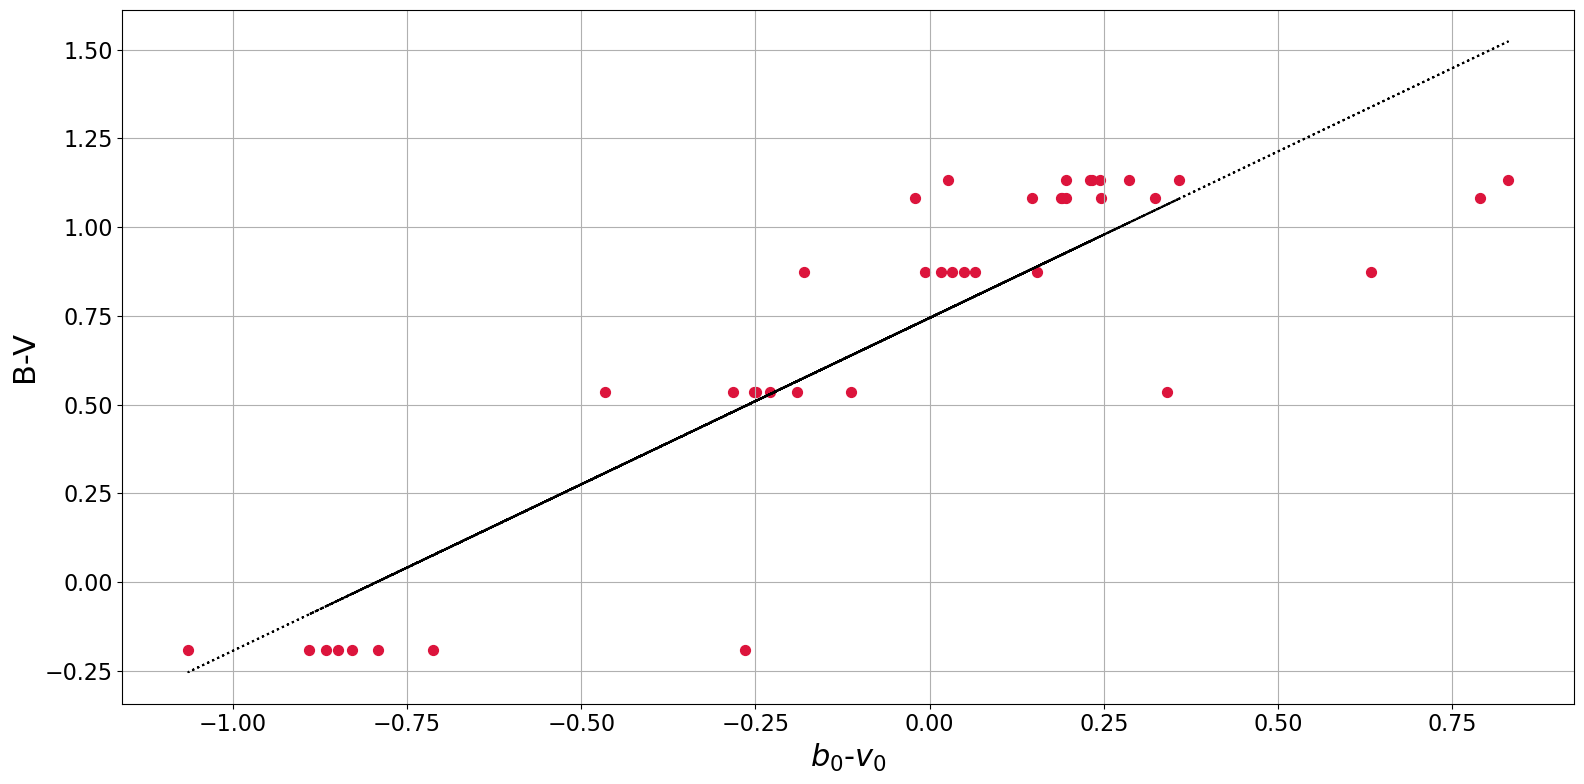

In [15]:
#plotting B-V as a function of (b-v)_0

x = []
y = []

fig = plt.figure(figsize=(16, 8))
for file in range(0,len(photometry[0])):             #for each file
    for star in range(0,len(photometry[0][file])):   #for each star
            B = landolt[star][columns[1]]            #B real mag for appropriate star in appropriate mag column
            V = landolt[star][columns[2]]            #V real mag for appropriate star in appropriate mag column
            b_0 = ext_corrected[1][file][star]       #b_0 inst mag
            v_0 = ext_corrected[2][file][star]       #v_0 inst mag
            x.append(b_0-v_0)
            y.append(B-V)
            plt.scatter(b_0-v_0, B-V, color='crimson', marker='o', s=50)
            
transf_coeff, zero_point = np.polyfit(x, y, 1)
print('B-V transformation coefficient:', transf_coeff)
print('B-V instrumental zero point:', zero_point)

B_coeff = transf_coeff + V_coeff
B_zp = zero_point + V_zp
print('B transformation coefficient:', B_coeff)
print('B instrumental zero point:', B_zp)

plt.plot(np.array(x), transf_coeff*np.array(x) + zero_point, color='black', ls='dotted')

plt.xlabel(r'$b_0$-$v_0$',fontsize=22)
plt.ylabel(r'B-V',fontsize=22)
fig.tight_layout()

V-R transformation coefficient: 0.4999287563942703
V-R instrumental zero point: 0.24015856061906188
R transformation coefficient: -0.322806234766045
R instrumental zero point: 27.64581878211493


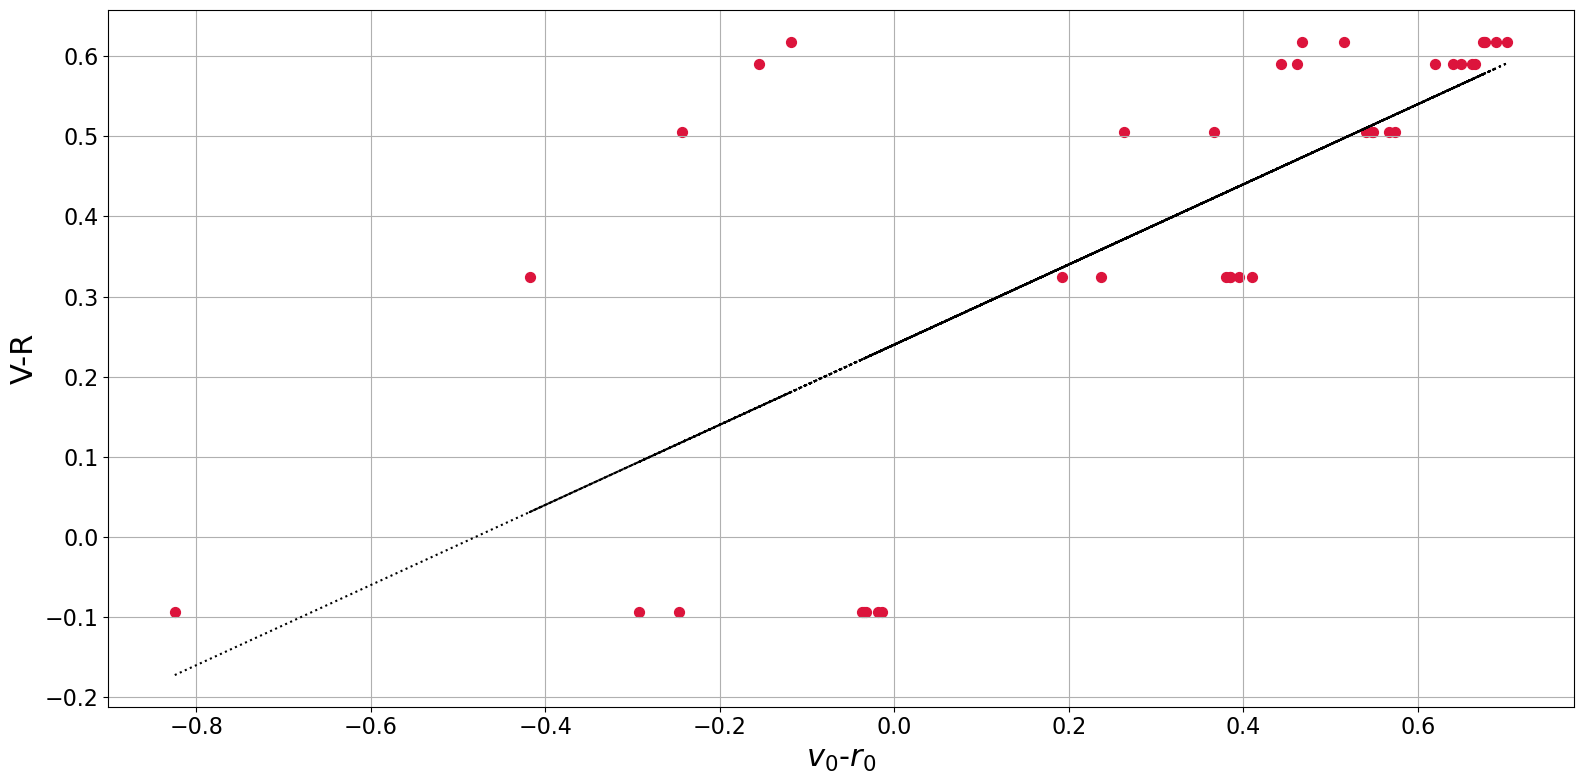

In [16]:
#plotting V-R as a function of (v-r)_0

x = []
y = []

fig, ax = plt.subplots(figsize=(16, 8))
for file in range(0,len(photometry[0])):             #for each file
    for star in range(0,len(photometry[0][file])):   #for each star
            R = landolt[star][columns[3]]            #R real mag for appropriate star in appropriate mag column
            V = landolt[star][columns[2]]            #V real mag for appropriate star in appropriate mag column
            r_0 = ext_corrected[3][file][star]       #r_0 inst mag
            v_0 = ext_corrected[2][file][star]       #v_0 inst mag
            x.append(v_0-r_0)
            y.append(V-R)
            ax.scatter(v_0-r_0, V-R, color='crimson', marker='o', s=50)
            
transf_coeff, zero_point = np.polyfit(x, y, 1)
print('V-R transformation coefficient:', transf_coeff)
print('V-R instrumental zero point:', zero_point)

R_coeff = V_coeff - transf_coeff
R_zp = V_zp - zero_point
print('R transformation coefficient:', R_coeff)
print('R instrumental zero point:', R_zp)

ax.plot(np.array(x), transf_coeff*np.array(x)+zero_point, color='black', ls='dotted')

ax.set_xlabel(r'$v_0$-$r_0$',fontsize=22)
ax.set_ylabel(r'V-R',fontsize=22)
fig.tight_layout()

U-B transformation coefficient: 0.7505736108257546
U-B instrumental zero point: -1.7130007118481663
U transformation coefficient: 1.8657072242634403
U instrumental zero point: 26.91743857776277


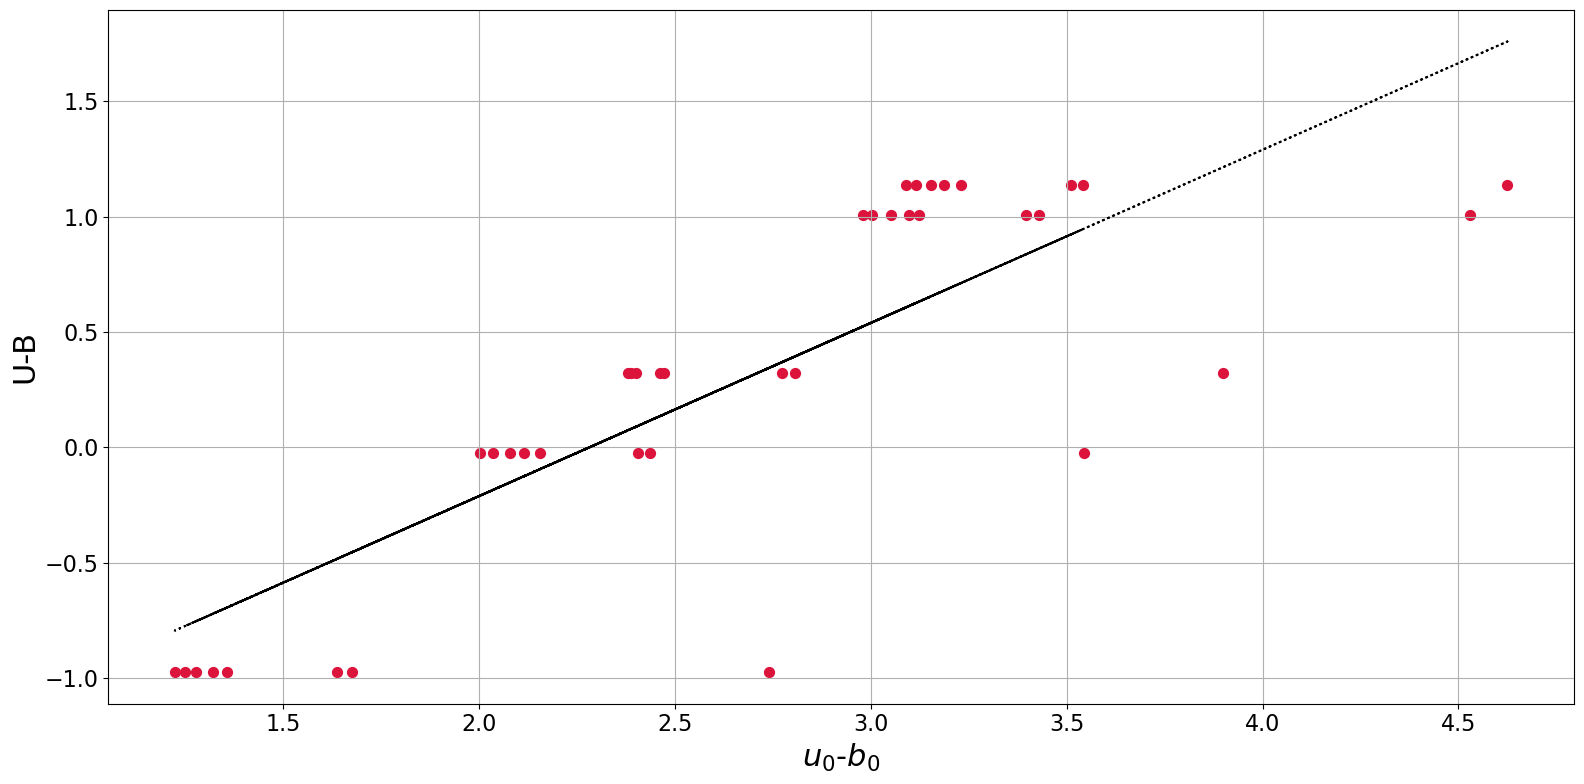

In [17]:
#plotting U-B as a function of (u-b)_0

x = []
y = []

fig, ax = plt.subplots(figsize=(16, 8))
for file in range(0,len(photometry[0])):             #for each file
    for star in range(0,len(photometry[0][file])):   #for each star
            U = landolt[star][columns[0]]            #U real mag for appropriate star in appropriate mag column
            B = landolt[star][columns[1]]            #B real mag for appropriate star in appropriate mag column
            u_0 = ext_corrected[0][file][star]       #u_0 inst mag
            b_0 = ext_corrected[1][file][star]       #b_0 inst mag
            x.append(u_0-b_0)
            y.append(U-B)
            ax.scatter(u_0-b_0, U-B, color='crimson', marker='o', s=50)
            
transf_coeff, zero_point = np.polyfit(x, y, 1)
print('U-B transformation coefficient:', transf_coeff)
print('U-B instrumental zero point:', zero_point)

U = (U-B) + B

U_coeff = transf_coeff + B_coeff
U_zp = zero_point + B_zp
print('U transformation coefficient:', U_coeff)
print('U instrumental zero point:', U_zp)

ax.plot(np.array(x), transf_coeff*np.array(x)+zero_point, color='black', ls='dotted')

ax.set_xlabel(r'$u_0$-$b_0$',fontsize=22)
ax.set_ylabel(r'U-B',fontsize=22)
fig.tight_layout()

R-I transformation coefficient: 0.8468547513450521
R-I instrumental zero point: 0.41909358503345
I transformation coefficient: -0.741899819799495
I instrumental zero point: 26.798964030769877


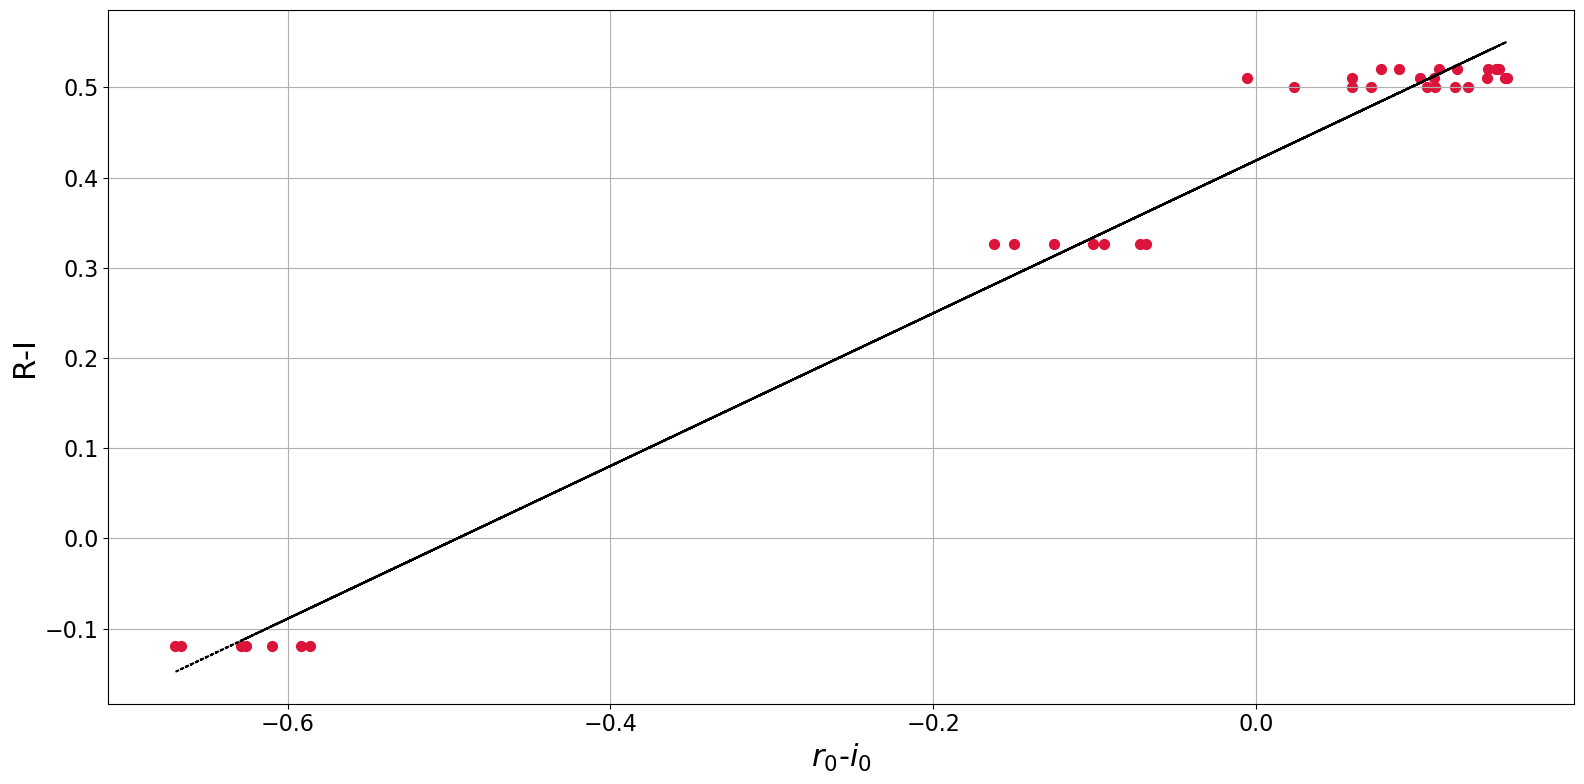

In [18]:
#plotting R-I as a function of (r-i)_0

x = []
y = []

fig, ax = plt.subplots(figsize=(16, 8))
for file in range(0,len(photometry[-1])):            #for each file
    for star in range(0,len(photometry[-1][file])):  #for each star
            R = landolt[star][columns[3]]            #R real mag for appropriate star in appropriate mag column
            I = landolt[star][columns[4]]            #I real mag for appropriate star in appropriate mag column
            r_0 = ext_corrected[3][file][star]       #r_0 inst mag
            i_0 = ext_corrected[4][file][star]       #i_0 inst mag
            x.append(r_0-i_0)
            y.append(R-I)
            ax.scatter(r_0-i_0, R-I, color='crimson', marker='o', s=50)
            
transf_coeff, zero_point = np.polyfit(x, y, 1)
print('R-I transformation coefficient:', transf_coeff)
print('R-I instrumental zero point:', zero_point)

I_coeff = R_coeff - zero_point
I_zp = R_zp - transf_coeff
print('I transformation coefficient:', I_coeff)
print('I instrumental zero point:', I_zp)

ax.plot(np.array(x), transf_coeff*np.array(x)+zero_point, color='black', ls='dotted')

ax.set_xlabel(r'$r_0$-$i_0$',fontsize=22)
ax.set_ylabel(r'R-I',fontsize=22)
fig.tight_layout()

In [19]:
coeffs = [U_coeff,B_coeff,V_coeff,R_coeff,I_coeff]
ZPs = [U_zp,B_zp,V_zp,R_zp,I_zp]

Okay, this was not exactly digestible as I definitely could've written a function or loop rather than re-plotting multiple times.

# Note: Kernel died, decided to do #3 in a "part 2" notebook.